# Deep Reinforcement Learning — Doom Agent (SS2025)

Welcome to the last assignment for the **Deep Reinforcement Learning** course (SS2025). In this notebook, you'll implement and train a reinforcement learning agent to play **Doom**.

You will:
- Set up a custom VizDoom environment with shaped rewards
- Train an agent using an approach of your choice
- Track reward components across episodes
- Evaluate the best model
- Visualize performance with replays and GIFs
- Export the trained agent to ONNX to submit to the evaluation server

In [1]:
# Clone repo
!git clone https://$token@github.com/gerkone/jku.wad.git
%cd jku.wad

Cloning into 'jku.wad'...
remote: Enumerating objects: 227, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 227 (delta 48), reused 50 (delta 45), pack-reused 169 (from 1)
Receiving objects: 100% (227/227), 973.43 KiB | 2.49 MiB/s, done.
Resolving deltas: 100% (135/135), done.
/content/jku.wad


In [2]:
# Install the dependencies
!pip install torch numpy matplotlib vizdoom portpicker gym onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 110.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 114.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [3]:
from typing import Dict, Sequence

import torch
from collections import deque, OrderedDict
from copy import deepcopy
import random
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
import vizdoom as vzd
from vizdoom import ScreenFormat

from gym import Env
from torch import nn
from einops import rearrange

from doom_arena import VizdoomMPEnv
from doom_arena.reward import VizDoomReward
from doom_arena.render import render_episode
from IPython.display import HTML
from typing import Dict, Tuple
from doom_arena.reward import VizDoomReward

## Environment configuration

ViZDoom supports multiple visual buffers that can be used as input for training agents. Each buffer provides different information about the game environment, as seen from left to right:


Screen
- The default first-person RGB view seen by the agent.

Labels
- A semantic map where each pixel is tagged with an object ID (e.g., enemy, item, wall).

Depth
- A grayscale map showing the distance from the agent to surfaces in the scene.

Automap
- A top-down schematic view of the map, useful for global navigation tasks.

![buffers gif](https://vizdoom.farama.org/_images/vizdoom-demo.gif)

In [4]:
USE_GRAYSCALE = False  # ← flip to False for RGB

PLAYER_CONFIG = {
    # NOTE: "algo_type" defaults to POLICY in evaluation script!
    "algo_type": "QVALUE",  # OPTIONAL, change to POLICY if using policy-based (eg PPO)
    "n_stack_frames": 1,
    "extra_state": ["depth"],
    "hud": "none",
    "crosshair": True,
    "screen_format": 8 if USE_GRAYSCALE else 0,
}

In [5]:
# TODO: environment training paramters
N_STACK_FRAMES = 1
NUM_BOTS = 4
EPISODE_TIMEOUT = 1000
# TODO: model hyperparams
GAMMA = 0.95
EPISODES = 500
BATCH_SIZE = 32
REPLAY_BUFFER_SIZE = 50000
LEARNING_RATE = 0.0001
n_steps = 2048
EPSILON_START = 1.0
EPSILON_END = 0.1
EPSILON_DECAY = 0.99
N_EPOCHS = 10

## Reward function
In this task, you will define a reward function to guide the agent's learning. The function is called at every step and receives the current and previous game variables (e.g., number of frags, hits taken, health).

Your goal is to combine these into a meaningful reward, encouraging desirable behavior, such as:

- Rewarding frags (enemy kills)

- Rewarding accuracy (hitting enemies)

- Penalizing damage taken

- (Optional) Encouraging survival, ammo efficiency, etc.

You can return multiple reward components, which are summed during training. Consider the class below as a great starting point!

In [6]:
class YourReward(VizDoomReward):
    def __init__(self, num_players: int):
        super().__init__(num_players)

    def __call__(
        self,
        vizdoom_reward: float,
        game_var: Dict[str, float],
        game_var_old: Dict[str, float],
        player_id: int,
    ) -> Tuple[float, float, float]:

        self._step += 1
        _ = vizdoom_reward, player_id

        rwd_hit = 4.0 * (game_var["HITCOUNT"] - game_var_old["HITCOUNT"])
        rwd_hit_taken = -0.1 * (game_var["HITS_TAKEN"] - game_var_old["HITS_TAKEN"])
        rwd_frag = 10.0 * (game_var["FRAGCOUNT"] - game_var_old["FRAGCOUNT"])

        return rwd_hit, rwd_hit_taken, rwd_frag

In [7]:
device = "cuda"
DTYPE = torch.float32

reward_fn = YourReward(num_players=1)

env = VizdoomMPEnv(
    num_players=1,
    num_bots=NUM_BOTS,
    bot_skill=0,
    doom_map="ROOM",  # NOTE simple, small map; other options: TRNM, TRNMBIG
    extra_state=PLAYER_CONFIG[
        "extra_state"
    ],  # see info about states at the beginning of 'Environment configuration' above
    episode_timeout=EPISODE_TIMEOUT,
    n_stack_frames=PLAYER_CONFIG["n_stack_frames"],
    crosshair=PLAYER_CONFIG["crosshair"],
    hud=PLAYER_CONFIG["hud"],
    screen_format=PLAYER_CONFIG["screen_format"],
    reward_fn=reward_fn,
)

Host 45601
Player 45601


## Agent

Implement **your own agent** in the code cell that follows.

* In `agents/dqn.py` and `agents/ppo.py` you'll find very small **skeletons**—they compile but are meant only as reference or quick tests.  
  Feel free to open them, borrow ideas, extend them, or ignore them entirely.
* The notebook does **not** import those files automatically; whatever class you define in the next cell is the one that will be trained.
* You may keep the DQN interface, switch to PPO, or try something else.
* Tweak any hyper-parameters (`PLAYER_CONFIG`, ε-schedule, optimiser, etc.) and document what you tried.


In [8]:

class DQN(nn.Module):

    def __init__(self, input_dim: int, action_space: int, hidden: int = 128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_dim, 32, kernel_size=8, stride=4, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
        )

        self.adaptive_pool = nn.AdaptiveAvgPool2d((6, 6))
        conv_out_size = 64 * 6 * 6
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(conv_out_size, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, action_space),
        )

    def forward(self, frame: torch.Tensor) -> torch.Tensor:
        x = self.encoder(frame)
        x = self.adaptive_pool(x)
        x = self.head(x)
        return x

In [9]:
@torch.no_grad()
def epsilon_greedy(
    env: Env,
    model: nn.Module,
    obs: torch.Tensor,
    epsilon: float,
    device: torch.device,
    dtype: torch.dtype,
):

    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        obs = obs.to(device, dtype=dtype).unsqueeze(0)
        return model(obs).argmax().item()


@torch.no_grad()
def update_ema(ema_model, model, decay: float = 0.995):
    ema_params = OrderedDict(ema_model.named_parameters())
    if hasattr(model, "module"):
        model_params = OrderedDict(model.module.named_parameters())
    else:
        model_params = OrderedDict(model.named_parameters())

    for name, param in model_params.items():
        ema_params[name].mul_(decay).add_(param.data, alpha=1 - decay)

In [10]:
in_channels = env.observation_space.shape[0]
model = DQN(
    input_dim=in_channels,
    action_space=env.action_space.n,
    hidden=128,
).to(device, dtype=DTYPE)
model_tgt = deepcopy(model).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

replay_buffer = deque(maxlen=REPLAY_BUFFER_SIZE)
epsilon = EPSILON_START
print(f"Model initialized with {sum(p.numel() for p in model.parameters())} parameters")
print(f"Input channels: {in_channels}, Action space: {env.action_space.n}")
print(f"Device: {device}, Dtype: {DTYPE}")

dummy_input = torch.randn(1, in_channels, *env.observation_space.shape[1:]).to(device, dtype=DTYPE)
with torch.no_grad():
    dummy_output = model(dummy_input)
    print(f"Model test successful! Input shape: {dummy_input.shape}, Output shape: {dummy_output.shape}")

Model initialized with 390568 parameters
Input channels: 4, Action space: 8
Device: cuda, Dtype: torch.float32
Model test successful! Input shape: torch.Size([1, 4, 192, 256]), Output shape: torch.Size([1, 8])


## Training loop

In [11]:
reward_list, q_loss_list = [], []
reward_components_log = []
best_eval_return, best_model = float("-inf"), None

for episode in range(EPISODES):
    ep_metrics = {
        "custom_reward": 0.0,
        "hit_reward": 0.0,
        "hit_taken_penalty": 0.0,
        "frag_reward": 0.0
    }
    obs = env.reset()[0]
    done, ep_return = False, 0.0
    model.eval()

    while not done:
        act = epsilon_greedy(env, model, obs, epsilon, device, DTYPE)
        next_obs, rwd_raw, done, _ = env.step(act)
        custom_rwd = float(rwd_raw[0])
        gv = env.envs[0].unwrapped._game_vars
        gv_pre = env.envs[0].unwrapped._game_vars_pre
        hit_rwd = 2.0 * (gv["HITCOUNT"] - gv_pre["HITCOUNT"])
        hit_taken_rwd = -0.1 * (gv["HITS_TAKEN"] - gv_pre["HITS_TAKEN"])
        frag_rwd = 100.0 * (gv["FRAGCOUNT"] - gv_pre["FRAGCOUNT"])

        ep_metrics["custom_reward"] += custom_rwd
        ep_metrics["hit_reward"] += hit_rwd
        ep_metrics["hit_taken_penalty"] += hit_taken_rwd
        ep_metrics["frag_reward"] += frag_rwd

        replay_buffer.append((obs, act, custom_rwd, next_obs[0], done))
        obs, ep_return = next_obs[0], ep_return + custom_rwd

    reward_list.append(ep_return)
    reward_components_log.append({
        "hit": ep_metrics["hit_reward"],
        "hit_taken": ep_metrics["hit_taken_penalty"],
        "frag": ep_metrics["frag_reward"],
        "total": ep_metrics["custom_reward"]
    })

    if len(replay_buffer) >= BATCH_SIZE:
        model.train()
        epoch_losses = []

        for _ in range(N_EPOCHS):
            batch = random.sample(replay_buffer, BATCH_SIZE)
            s, a, r, s2, d = zip(*batch)
            s = torch.stack(s).to(device, dtype=DTYPE)
            s2 = torch.stack(s2).to(device, dtype=DTYPE)
            a = torch.tensor(a, device=device)
            r = torch.tensor(r, device=device, dtype=torch.float32)
            d = torch.tensor(d, device=device, dtype=torch.float32)
            q = model(s).gather(1, a.unsqueeze(1)).squeeze(1)

            with torch.no_grad():
                q2 = model_tgt(s2).max(1).values
                tgt = r + GAMMA * q2 * (1 - d)

            loss = F.mse_loss(q, tgt)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            epoch_losses.append(loss.item())

        update_ema(model_tgt, model, decay=0.995)
        q_loss_list.extend(epoch_losses)

    scheduler.step()
    epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)
    print(f"Ep {episode+1:03}: return {ep_return:6.1f}  |  ε {epsilon:.3f}  |  "
          f"frags: {ep_metrics['frag_reward']:4.0f}  |  hits: {ep_metrics['hit_reward']:4.0f}")

    if episode % 10 == 0:
        eval_obs, done, eval_return = env.reset()[0], False, 0.0
        model.eval()
        while not done:
            act = epsilon_greedy(env, model, eval_obs, 0.05, device, DTYPE)
            eval_obs_n, r, done, _ = env.step(act)
            eval_obs = eval_obs_n[0]
            eval_return += r[0]

        if eval_return > best_eval_return:
            best_eval_return, best_model = eval_return, deepcopy(model)
            print(f"  → New best model! Eval return: {eval_return:.1f}")

final_model = best_model if best_model is not None else model

print(f"\nTraining completed! Best evaluation return: {best_eval_return:.1f}")
print(f"Final epsilon: {epsilon:.3f}")
print(f"Total training steps: {len(q_loss_list)}")

Ep 001: return   -1.3  |  ε 0.990  |  frags:    0  |  hits:    0
  → New best model! Eval return: 19.8
Ep 002: return   -0.2  |  ε 0.980  |  frags:    0  |  hits:    0
Ep 003: return   -0.2  |  ε 0.970  |  frags:    0  |  hits:    0
Ep 004: return    0.0  |  ε 0.961  |  frags:    0  |  hits:    0
Ep 005: return   -0.8  |  ε 0.951  |  frags:    0  |  hits:    0
Ep 006: return    0.0  |  ε 0.941  |  frags:    0  |  hits:    0
Ep 007: return   -1.6  |  ε 0.932  |  frags:    0  |  hits:    0
Ep 008: return   -1.9  |  ε 0.923  |  frags:    0  |  hits:    0
Ep 009: return   -0.2  |  ε 0.914  |  frags:    0  |  hits:    0
Ep 010: return   -0.3  |  ε 0.904  |  frags:    0  |  hits:    0
Ep 011: return   -0.3  |  ε 0.895  |  frags:    0  |  hits:    0
Ep 012: return   -1.8  |  ε 0.886  |  frags:    0  |  hits:    0
Ep 013: return   -0.1  |  ε 0.878  |  frags:    0  |  hits:    0
Ep 014: return   -0.3  |  ε 0.869  |  frags:    0  |  hits:    0
Ep 015: return   -0.9  |  ε 0.860  |  frags:    0  |

## Dump to ONNX

In [12]:
import onnx
import json

def onnx_dump(env, model, config, filename: str):

    init_state = env.reset()[0].unsqueeze(0)
    torch.onnx.export(
        model.cpu(),
        args=init_state,
        f=filename,
        export_params=True,
        opset_version=11,
        do_constant_folding=True,
        input_names=["input"],
        output_names=["output"],
        dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
    )
    onnx_model = onnx.load(filename)
    meta = onnx_model.metadata_props.add()
    meta.key = "config"
    meta.value = json.dumps(config)

    onnx.save(onnx_model, filename)

onnx_dump(env, final_model, PLAYER_CONFIG, filename="model.onnx")
print("Best network exported to model.onnx")

Best network exported to model.onnx


### Evaluation and Visualization

In this final section, you can evaluate your trained agent, inspect its performance visually, and analyze reward components over time.


Training Progress:


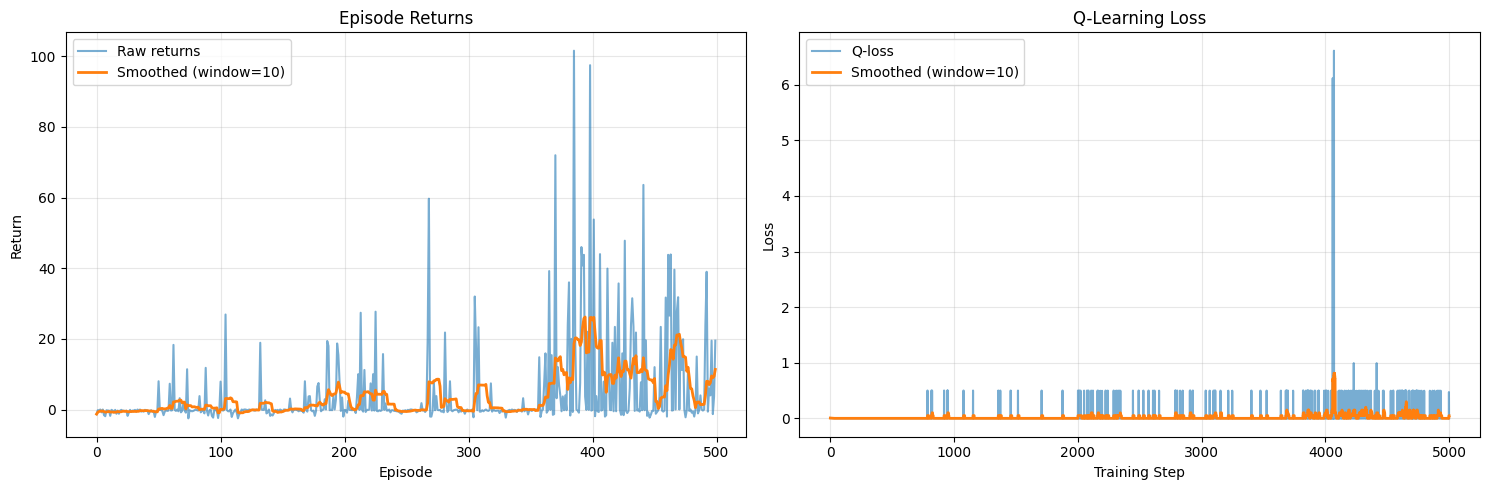


Reward Components:


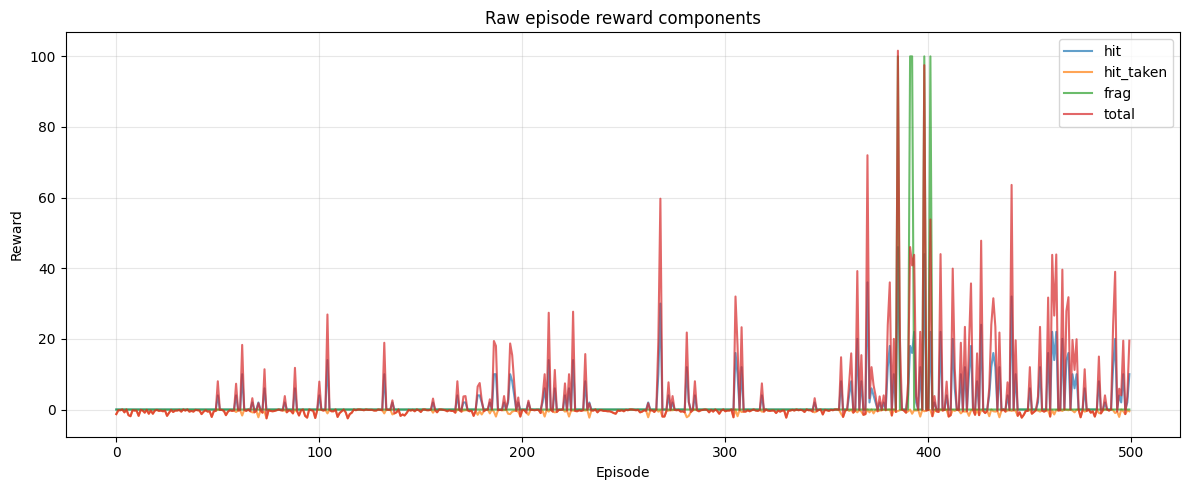

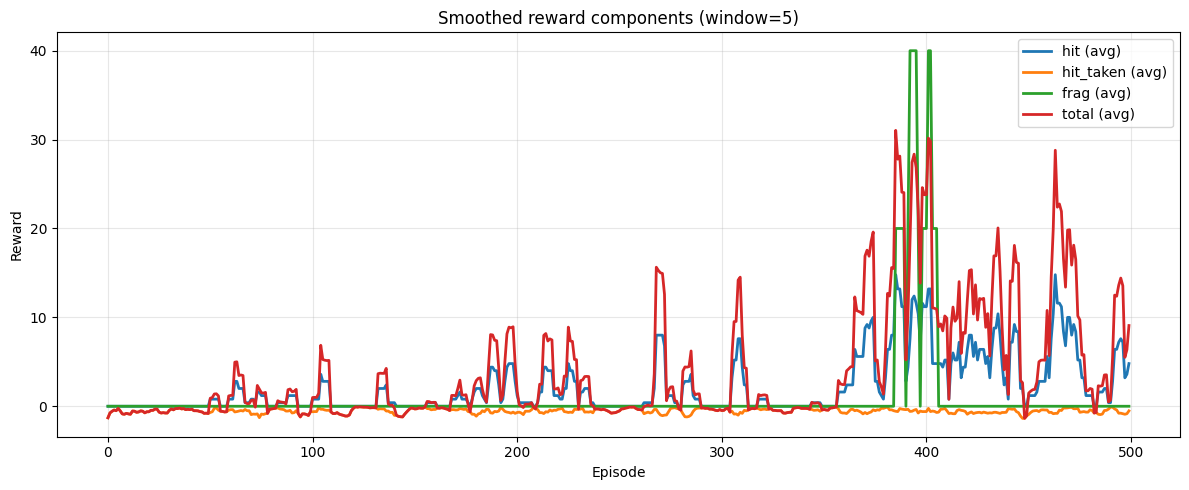


Evaluation complete! You can now test the exported model.onnx file.


In [13]:
def plot_reward_components(reward_log, smooth_window: int = 5):

    if not reward_log:
        print("reward_log is empty – nothing to plot.")
        return

    df = pd.DataFrame(reward_log)
    df_smooth = df.rolling(window=smooth_window, min_periods=1).mean()
    plt.figure(figsize=(12, 5))
    for col in df.columns:
        plt.plot(df.index, df[col], label=col, alpha=0.7)
    plt.title("Raw episode reward components")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(12, 5))
    for col in df.columns:
        plt.plot(df.index, df_smooth[col], label=f"{col} (avg)", linewidth=2)
    plt.title(f"Smoothed reward components (window={smooth_window})")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_training_progress(reward_list, q_loss_list, smooth_window: int = 10):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    episodes = range(len(reward_list))
    ax1.plot(episodes, reward_list, alpha=0.6, label='Raw returns')
    if len(reward_list) >= smooth_window:
        smoothed = pd.Series(reward_list).rolling(window=smooth_window, min_periods=1).mean()
        ax1.plot(episodes, smoothed, linewidth=2, label=f'Smoothed (window={smooth_window})')
    ax1.set_title('Episode Returns')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Return')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    if q_loss_list:
        steps = range(len(q_loss_list))
        ax2.plot(steps, q_loss_list, alpha=0.6, label='Q-loss')
        if len(q_loss_list) >= smooth_window:
            smoothed_loss = pd.Series(q_loss_list).rolling(window=smooth_window, min_periods=1).mean()
            ax2.plot(steps, smoothed_loss, linewidth=2, label=f'Smoothed (window={smooth_window})')
        ax2.set_title('Q-Learning Loss')
        ax2.set_xlabel('Training Step')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

print("Training Progress:")
plot_training_progress(reward_list, q_loss_list)

print("\nReward Components:")
plot_reward_components(reward_components_log)
print("\nEvaluation complete! You can now test the exported model.onnx file.")

Enabling replays!
Running evaluation episode for visualization...
Evaluation episode completed! Return: 93.30, Steps: 1000
Disabling replays!
Rendering video... (this may take a moment)


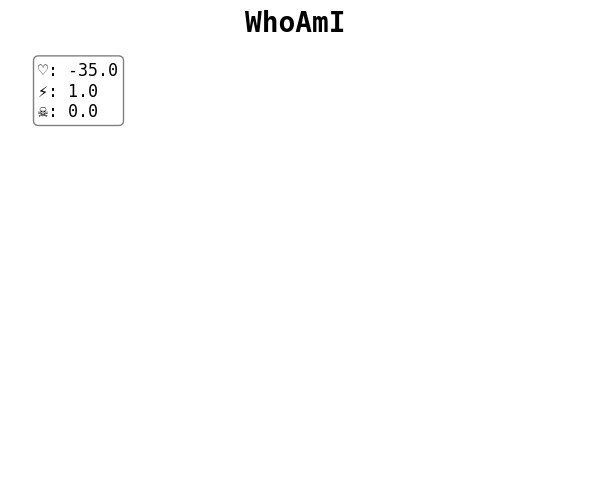

In [16]:
final_model = final_model.to(device)
env.enable_replay()
print("Running evaluation episode for visualization...")
obs = env.reset()[0]
done = False
episode_return = 0.0
step_count = 0

final_model.eval()
with torch.no_grad():
    while not done and step_count < 1000:
        action = epsilon_greedy(env, final_model, obs, epsilon=0.05, device=device, dtype=DTYPE)
        obs, reward, done, _ = env.step(action)
        obs = obs[0]
        episode_return += reward[0]
        step_count += 1

print(f"Evaluation episode completed! Return: {episode_return:.2f}, Steps: {step_count}")
env.disable_replay()
replays = env.get_player_replays()

from doom_arena.render import render_episode
from IPython.display import HTML

print("Rendering video... (this may take a moment)")
video = render_episode(replays, subsample=5)
HTML(video.to_html5_video())
